# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

from tqdm.auto import tqdm

import numpy as np
import h5py

import matplotlib.pyplot as plt

import seaborn as sns; sns.set_theme()

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from torch.optim.lr_scheduler import StepLR

In [3]:
!pip install einops

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
os.chdir("/content/drive/MyDrive/MRViT")

In [6]:
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO
from models.mrvit import MultiResViT

In [7]:
data_flag = 'retinamnist'
info = INFO[data_flag]
task = info['task']

In [10]:
from dataset.dataset import get_datasets

In [8]:
random_seed = 101
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = "cuda:0"
    print('using device: cuda')
else:
    device = "cpu"
    print('using device: cpu')

using device: cuda


# Dataset

In [11]:
train_dataset, valid_dataset, test_dataset = get_datasets()

<KeysViewHDF5 ['label_test', 'label_train', 'test', 'test_small', 'train', 'train_small']>
torch.Size([400, 112, 112, 3]) torch.Size([400, 28, 28, 3]) torch.Size([400, 1])
1078 1080


In [12]:
BATCH_SIZE = 128

In [13]:
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
for batch_data in train_loader:
    print(batch_data[0].shape)
    print(batch_data[1].shape)
    print(batch_data[2].shape)
    break

torch.Size([128, 3, 28, 28])
torch.Size([128, 3, 112, 112])
torch.Size([128, 1])


# Merged Model

In [15]:
mrv = MultiResViT(4)

img_s = torch.randn(2, 3, 28, 28)
img_b = torch.randn(2, 3, 112, 112)

pred = mrv(img_s, img_b)

print(pred)

tensor([[-0.0506, -0.0743,  0.1287, -0.0964],
        [-0.0495, -0.0711,  0.1271, -0.1004]], grad_fn=<AddmmBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training


In [16]:
weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_dataset.get_labels().numpy()),
                                                 train_dataset.get_labels().numpy())
weights = torch.FloatTensor(weights).to(device)

In [17]:
weights

tensor([0.4685, 1.4978, 1.0632, 1.1464, 2.5975], device='cuda:0')

In [18]:
batch_size = 128
epochs = 20
lr = 7.5e-4
decay = 0.0
gamma = 0.7

model = MultiResViT(nclasses = 5) #Put model to be trained and tested
model.to(device)

# loss function
criterion = nn.CrossEntropyLoss(weight = weights)
# optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=decay)
# scheduler
scheduler = StepLR(optimizer, step_size = 1, gamma=gamma)

In [19]:
keys = ['epochs', 'loss', 'acc', 'val_loss', 'val_acc']
history = {key: [] for key in keys}

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in tqdm(train_loader):
        images_s = batch_data[0].to(device)
        images_l = batch_data[1].to(device)
        label = batch_data[2].to(device)

        output = model(images_s, images_l)

        loss = criterion(output.float(), label.squeeze())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc 
        epoch_loss += loss 

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for batch_data in tqdm(valid_loader):
            images_s = batch_data[0].to(device)
            images_l = batch_data[1].to(device)
            label = batch_data[2].to(device)

            val_output = model(images_s, images_l)
            val_loss = criterion(val_output.float(), label.squeeze())

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc 
            epoch_val_loss += val_loss
    
    scheduler.step()

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss/ len(train_loader):.4f} - acc: {epoch_accuracy/ len(train_loader):.4f} \
        - val_loss : {epoch_val_loss / len(valid_loader):.4f} - val_acc: {epoch_val_accuracy / len(valid_loader):.4f}\n"
    )
    history['epochs'].append(epoch+1)
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_accuracy)
    history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_accuracy)


Epoch : 1 - loss : 1.6110 - acc: 0.2648         - val_loss : 1.5989 - val_acc: 0.1914




Epoch : 2 - loss : 1.6160 - acc: 0.1829         - val_loss : 1.5695 - val_acc: 0.3395




Epoch : 3 - loss : 1.5394 - acc: 0.2854         - val_loss : 1.5061 - val_acc: 0.3025




Epoch : 4 - loss : 1.4583 - acc: 0.2530         - val_loss : 1.4564 - val_acc: 0.3210




Epoch : 5 - loss : 1.6028 - acc: 0.2466         - val_loss : 1.4529 - val_acc: 0.3066




Epoch : 6 - loss : 1.4801 - acc: 0.2898         - val_loss : 1.4877 - val_acc: 0.2829




Epoch : 7 - loss : 1.5354 - acc: 0.2849         - val_loss : 1.4779 - val_acc: 0.2726




Epoch : 8 - loss : 1.4682 - acc: 0.2896         - val_loss : 1.4421 - val_acc: 0.2994




Epoch : 9 - loss : 1.4562 - acc: 0.2515         - val_loss : 1.4240 - val_acc: 0.2942




Epoch : 10 - loss : 1.4824 - acc: 0.2179         - val_loss : 1.4175 - val_acc: 0.2767




Epoch : 11 - loss : 1.4730 - acc: 0.2680         - val_loss : 1.4058 - val_acc: 0.2767




Epoch : 12 - loss : 1.3991 - acc: 0.2673         - val_loss : 1.4027 - val_acc: 0.2747




Epoch : 13 - loss : 1.4613 - acc: 0.2105         - val_loss : 1.3920 - val_acc: 0.2726




Epoch : 14 - loss : 1.3951 - acc: 0.2340         - val_loss : 1.3889 - val_acc: 0.2695




Epoch : 15 - loss : 1.3985 - acc: 0.2361         - val_loss : 1.3955 - val_acc: 0.2654




Epoch : 16 - loss : 1.4532 - acc: 0.2101         - val_loss : 1.3926 - val_acc: 0.2716




Epoch : 17 - loss : 1.4039 - acc: 0.2347         - val_loss : 1.3812 - val_acc: 0.2695




Epoch : 18 - loss : 1.4680 - acc: 0.2090         - val_loss : 1.3891 - val_acc: 0.2644




Epoch : 19 - loss : 1.4116 - acc: 0.2348         - val_loss : 1.3738 - val_acc: 0.2716




Epoch : 20 - loss : 1.4292 - acc: 0.2070         - val_loss : 1.3726 - val_acc: 0.2716



In [20]:
output

tensor([[-0.0362,  0.0279,  0.1332,  0.1531, -0.0918],
        [-0.0885, -0.0196,  0.1015,  0.1475,  0.0047]], device='cuda:0',
       grad_fn=<AddmmBackward>)

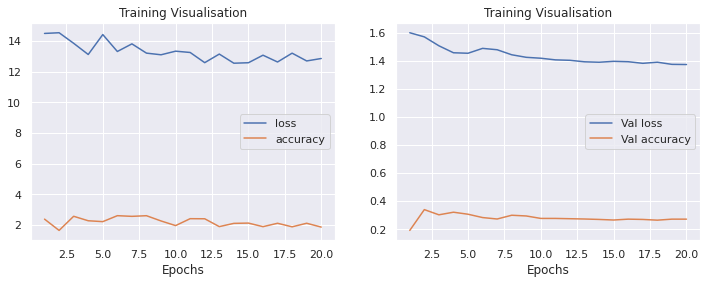

In [21]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['epochs'], history['loss'], label='loss') 
plt.plot(history['epochs'], history['acc'], label='accuracy')
plt.xlabel('Epochs')
plt.title("Training Visualisation")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['epochs'], history['val_loss'], label='Val loss')  
plt.plot(history['epochs'], history['val_acc'], label='Val accuracy')
plt.xlabel('Epochs')
plt.title("Training Visualisation")
plt.legend()

In [22]:
images_s, images_l = test_dataset.get_images()
label = test_dataset.get_labels()
model = model.cpu()
preds = model(images_s, images_l)

acc = getACC(label, preds.detach().cpu().numpy(), task = task)
auc = getAUC(label, preds.detach().cpu().numpy(), task = task)
print(f"ACC Model: {acc}, AUC Model: {auc}")

ACC Model: 0.3925, AUC Model: 0.6904367036166429


In [23]:
pred = np.zeros_like(label)
for i in range(preds.shape[0]):
    pred[i] = np.argmax(preds.detach().cpu().numpy()[i])

print(classification_report(label, pred))

              precision    recall  f1-score   support

         0.0       0.82      0.74      0.77       174
         1.0       0.00      0.00      0.00        46
         2.0       0.00      0.00      0.00        92
         3.0       0.18      0.22      0.20        68
         4.0       0.09      0.70      0.16        20

    accuracy                           0.39       400
   macro avg       0.22      0.33      0.23       400
weighted avg       0.39      0.39      0.38       400



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
